In [8]:
import pandas as pd
import os
import numpy as np
import re
import matplotlib.pyplot as plt

In [9]:
# Arbeitsverzeichnis ändern 
#neues_verzeichnis = "c:\\Users\\lpres\\OneDrive - JGU\\WMDV\\WebMining_final"
neues_verzeichnis = "C:\\Users\\Lucian\\Desktop\\WebMining_final"
os.chdir(neues_verzeichnis)

# Überprüfen, ob das Verzeichnis geändert wurde
print("Neues Arbeitsverzeichnis:", os.getcwd())

Neues Arbeitsverzeichnis: C:\Users\Lucian\Desktop\WebMining_final


In [3]:
# Alle vorhandenen owned_games_x Dateien finden
owned_files = [f for f in os.listdir('.') if re.match(r'owned_games_\d+\.csv', f)]
owned_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

print(f"Vorhandene Dateien: {owned_files}")

if not owned_files:
    print("Keine Dateien im Format 'owned_games_x.csv' gefunden. Das Skript wird beendet.")

# Alle Dateien einlesen und in einem DataFrame speichern
pre_df = pd.DataFrame()  # Leerer DataFrame

for file in owned_files:
    file_df = pd.read_csv(file, dtype={
         "steam_64_id": str,
         "appid": "Int64",  
         "playtime_forever": "Int64",
         "playtime_2weeks": "Int64"
    })
    pre_df = pd.concat([pre_df, file_df], ignore_index=True)

print("alle Dateien eingelesen")
print(pre_df.shape)

Vorhandene Dateien: ['owned_games_1.csv', 'owned_games_2.csv', 'owned_games_3.csv', 'owned_games_4.csv', 'owned_games_5.csv', 'owned_games_6.csv', 'owned_games_7.csv', 'owned_games_8.csv', 'owned_games_9.csv']


C:\Users\Lucian\AppData\Local\Temp\ipykernel_7804\35310863.py:14: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  file_df = pd.read_csv(file, dtype={


alle Dateien eingelesen
(10245880, 6)


In [4]:
# Duplikate und "No Games" rausschmeißen
h_df = pre_df.drop_duplicates(keep="first")
h_df = h_df[h_df["name"] != "No Games"]
dropped_rows = pre_df.shape[0] - h_df.shape[0]
print(h_df.shape)
print(f"{dropped_rows} Duplikate wurden entfernt")

(5800632, 6)
4445248 Duplikate wurden entfernt


In [47]:
# Sortieren nach höchster Spielzeit und dann Duplikate entfernen. Falls steam_id mehrfach abgefragt wurde, sollen die einträge behalten werden, die am neuesten sind (max(playtime_forever))
df = h_df.sort_values(by="playtime_forever", ascending=False).drop_duplicates(subset=["steam_64_id", "appid"], keep="first")

# Anzahl der entfernten Duplikate berechnen
dropped_rows = h_df.shape[0] - df.shape[0]

print(df.shape)
print(f"{dropped_rows} Duplikate wurden entfernt (behalten wurde die Zeile mit der höchsten Spielzeit pro Spieler-Spiel-Kombination).")

(5735873, 6)
64759 Duplikate wurden entfernt (behalten wurde die Zeile mit der höchsten Spielzeit pro Spieler-Spiel-Kombination).


In [79]:
# nicht gespielte Spiele für jeden Spieler entfernen

min_playtime = 240

n_df = df[df['playtime_forever'] >= min_playtime]

dropped_rows = df.shape[0] - n_df.shape[0]
print(f"{dropped_rows} Zeilen mit playtime_forever < {min_playtime} wurden entfernt")
print(n_df.shape)
print(n_df.head())

4174423 Zeilen mit playtime_forever < 240 wurden entfernt
(1561450, 6)
               steam_64_id  appid              name  playtime_forever  \
3452706  76561198146907668    570            Dota 2           3942986   
1234970  76561198146907680    570            Dota 2           3933584   
6227704  76561198187952678    570            Dota 2           3422555   
1734547  76561198187952672    570            Dota 2           3422527   
8775426  76561198393005716    730  Counter-Strike 2           3313278   

         playtime_2weeks has_community_visible_stats  
3452706            17855                       False  
1234970            17601                        True  
6227704               42                       False  
1734547               24                        True  
8775426            20037                        True  


count           42727.0
mean      396414.320266
std      1391205.377777
min               241.0
1%              6242.98
25%            141032.0
50%            282720.0
75%            480909.0
99%          1557998.62
max         102792643.0
Name: total_playtime_forever, dtype: Float64


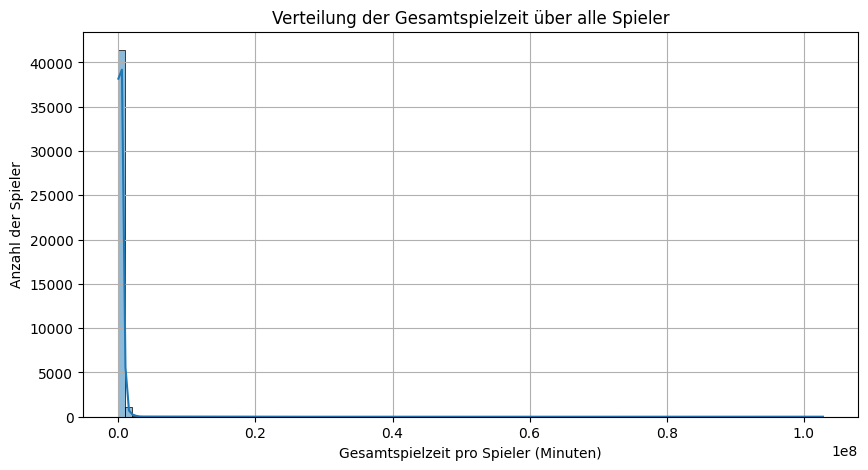

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Gesamtspielzeit pro Spieler berechnen
df_player = n_df.groupby('steam_64_id').agg(total_playtime_forever=('playtime_forever', 'sum')).reset_index()

# Statistik der Gesamtspielzeit
stats = df_player['total_playtime_forever'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
print(stats)

# Histogramm der Gesamtspielzeit
plt.figure(figsize=(10, 5))
sns.histplot(df_player['total_playtime_forever'], bins=100, kde=True)
plt.xlabel("Gesamtspielzeit pro Spieler (Minuten)")
plt.ylabel("Anzahl der Spieler")
plt.title("Verteilung der Gesamtspielzeit über alle Spieler")
plt.grid()
plt.show()

In [81]:
# Perzentile berechnen
percentiles = df_player['total_playtime_forever'].quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999])

# Perzentile ausgeben
print(percentiles)


0.010         6242.98
0.050         33002.3
0.100         61301.0
0.250        141032.0
0.500        282720.0
0.750        480909.0
0.900        710024.4
0.950        892313.7
0.990      1557998.62
0.999    11824494.724
Name: total_playtime_forever, dtype: Float64


In [82]:
# Spieler mit realistischen Spielzeiten behalten
df_player_filtered = df_player[
    (df_player['total_playtime_forever'] > 10000) & 
    (df_player['total_playtime_forever'] < 1500000)
]

print(f"Anzahl der Spieler nach Filtering: {df_player_filtered.shape[0]}")


Anzahl der Spieler nach Filtering: 41623


count          41623.0
mean     341655.109435
std      256077.750604
min            10009.0
1%             16491.4
25%           145324.0
50%           284117.0
75%           476006.5
99%         1164013.68
max          1499508.0
Name: total_playtime_forever, dtype: Float64


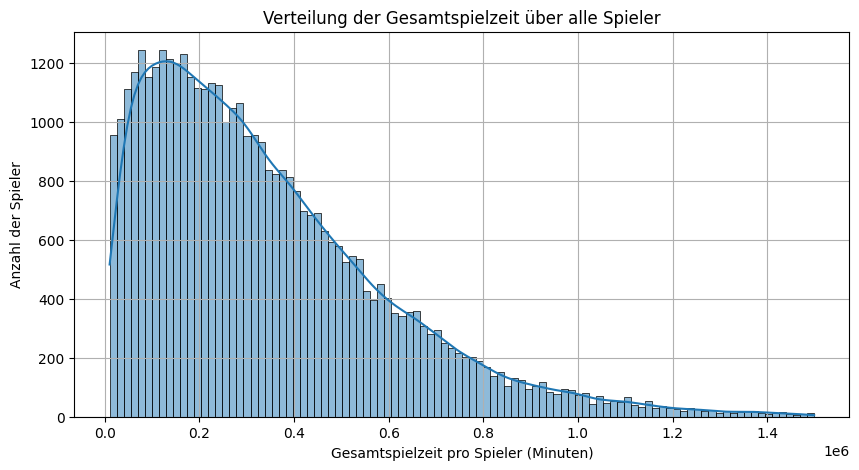

In [83]:
# Statistik der Gesamtspielzeit
stats = df_player_filtered['total_playtime_forever'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
print(stats)

# Histogramm der Gesamtspielzeit
plt.figure(figsize=(10, 5))
sns.histplot(df_player_filtered['total_playtime_forever'], bins=100, kde=True)
plt.xlabel("Gesamtspielzeit pro Spieler (Minuten)")
plt.ylabel("Anzahl der Spieler")
plt.title("Verteilung der Gesamtspielzeit über alle Spieler")
plt.grid()
plt.show()

In [96]:
# Alle relevanten Spieler-IDs extrahieren
filtered_players = df_player_filtered['steam_64_id'].unique()

# Den ursprünglichen Spieldatensatz (`df_filtered_games`) auf diese Spieler beschränken
df_filtered_games = n_df[n_df['steam_64_id'].isin(filtered_players)].copy()

# Anzahl Spiele
unique_games = df_filtered_games['appid'].nunique()

# Den häufigsten Namen für jedes Spiel bestimmen
game_names = df_filtered_games.groupby('appid')['name'].agg(lambda x: x.mode()[0]).reset_index()

# Gesamtspielzeit pro Spiel berechnen (über alle Spieler summiert)
game_playtime = df_filtered_games.groupby('appid')['playtime_forever'].sum().reset_index()
game_playtime = game_playtime.merge(game_names, on='appid', how='left')
game_playtime = game_playtime[['appid', 'name', 'playtime_forever']]
game_playtime = game_playtime.sort_values(by='playtime_forever', ascending=False)

# Überprüfung
print(f"Neue Shape des Datensatzes: {df_filtered_games.shape}")
print(f"Anzahl der Spieler in df_filtered_games nach Filterung: {df_filtered_games['steam_64_id'].nunique()}")
print(f"Anzahl der Spiele: {unique_games}")
print(game_playtime)


Neue Shape des Datensatzes: (1402046, 6)
Anzahl der Spieler in df_filtered_games nach Filterung: 41623
Anzahl der Spiele: 19528
         appid                                               name  \
21         570                                             Dota 2   
24         730                                   Counter-Strike 2   
9131    578080                                PUBG: BATTLEGROUNDS   
2439    271590                                 Grand Theft Auto V   
2022    252490                                               Rust   
...        ...                                                ...   
13318  1073900                                             Brukel   
4858    371880                                           Collider   
13633  1119970                                          Elf Manor   
17030  1833490                                      GOODBYE WORLD   
3076    302110  Small Town Terrors Pilgrim's Hook Collector's ...   

       playtime_forever  
21           7384

In [95]:
# Perzentile für die Gesamtspielzeit pro Spiel (über alle Spieler summiert) berechnen
game_playtime_percentiles = game_playtime['playtime_forever'].quantile(
    [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
)

# Perzentile ausgeben
print(game_playtime_percentiles)

0.010           254.0
0.050          325.35
0.100           537.7
0.250          1423.0
0.500          5458.5
0.750         22109.5
0.900        104224.3
0.950        348227.0
0.990      3671489.17
0.999    43196496.866
Name: playtime_forever, dtype: Float64


In [100]:
df_filtered_games.to_csv("filtered_games.csv", index=False)

In [93]:
# Obergrenze für die meistgespielten 1% der Spiele setzen
upper_threshold = game_playtime['playtime_forever'].quantile(0.99)

# Liste der Spiele, die in den oberen 1% liegen
top_1_percent_games = game_playtime[game_playtime['playtime_forever'] >= upper_threshold]['appid']

# Anzahl der Spieler pro Top-1%-Spiel berechnen & sortieren
top_1_percent_player_counts_sorted = df_filtered_games[df_filtered_games['appid'].isin(top_1_percent_games)] \
    .groupby('appid')['steam_64_id'].nunique().reset_index() \
    .rename(columns={'steam_64_id': 'player_count'}) \
    .sort_values(by='player_count', ascending=False)

# Ergebnisse anzeigen
print(upper_threshold)
print(top_1_percent_player_counts_sorted)

3671489.169999992
       appid  player_count
4        570         35021
6        730         30975
102   578080         21439
79    431960         14026
42    271590         11039
..       ...           ...
121   786520           185
175  1569040           160
141  1100600           158
156  1283970            82
93    524660            49

[196 rows x 2 columns]


C:\Users\Lucian\AppData\Local\Temp\ipykernel_7804\1381101736.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Lucian\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38592 (\N{CJK UNIFIED IDEOGRAPH-96C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lucian\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39746 (\N{CJK UNIFIED IDEOGRAPH-9B42}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lucian\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40635 (\N{CJK UNIFIED IDEOGRAPH-9EBB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lucian\AppData\Roaming\Python\Python31

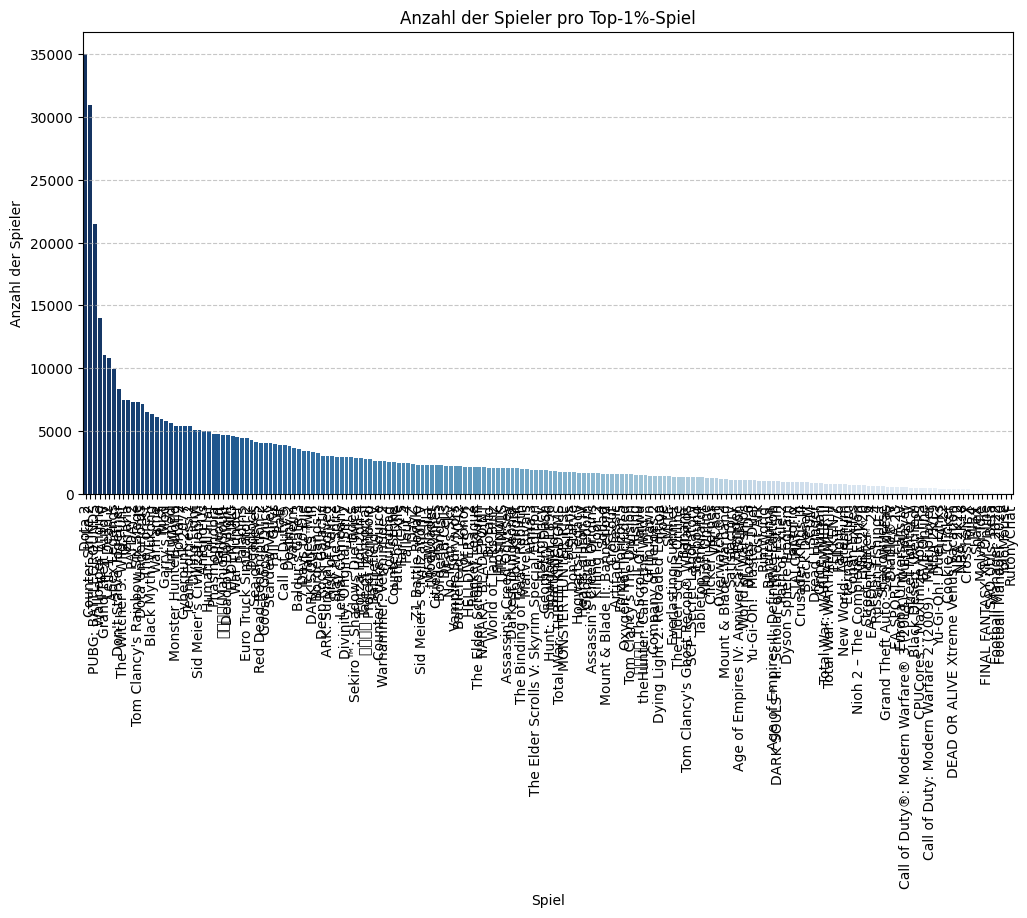

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Spielnamen zur Top-1%-Spielerzahl-Tabelle hinzufügen
top_1_percent_names = df_filtered_games.groupby('appid')['name'].agg(lambda x: x.mode()[0]).reset_index()
top_1_percent_player_counts_sorted = top_1_percent_player_counts_sorted.merge(
    top_1_percent_names, on='appid', how='left'
)

# Visualisierung der Anzahl der Spieler pro Spiel (Top 1% der meistgespielten Spiele)
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_1_percent_player_counts_sorted['name'],
    y=top_1_percent_player_counts_sorted['player_count'],
    palette="Blues_r"
)

plt.xticks(rotation=90)  # Drehung der Namen für bessere Lesbarkeit
plt.xlabel("Spiel")
plt.ylabel("Anzahl der Spieler")
plt.title("Anzahl der Spieler pro Top-1%-Spiel")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [43]:
import pandas as pd

#  Sicherstellen, dass der Pfad korrekt ist
genre_file_path = r"C:\Users\Lucian\Desktop\WebMining_final\unique_games_updated.csv"

#  CSV-Datei mit automatischer Trennzeichenerkennung laden
df_genre = pd.read_csv(genre_file_path, sep=None, engine="python", on_bad_lines="skip")

#  Prüfen, ob die Spalte "genre" existiert
if 'genre' not in df_genre.columns:
    raise ValueError("Die Spalte 'genre' fehlt in df_genre!")

#  Genres als **Liste** speichern (statt feste Spalten)
df_genre['genre_list'] = df_genre['genre'].str.split(',')

#  Unnötige Original-Spalte 'genre' entfernen (optional)
df_genre.drop(columns=['genre'], inplace=True)

#  Ergebnisse prüfen
print(df_genre.head())
print(f"Beispiel für genre_list: {df_genre['genre_list'].iloc[0]}")
print(f"Anzahl der Spalten nach Anpassung: {df_genre.shape[1]}")


         steam_64_id   appid                    name  playtime_forever  \
0  76561198217215311  304930                Unturned                 0   
1  76561198217215311  444090                Paladins                 0   
2  76561198217215311  596350  Paladins - Public Test                 0   
3  76561198217215311     730        Counter-Strike 2                 0   
4  76561198213997533  218230            PlanetSide 2                 0   

   playtime_2weeks  has_community_visible_stats  \
0                0                         True   
1                0                         True   
2                0                        False   
3                0                         True   
4                0                        False   

                                          genre_list  
0  [action,  adventure,  indie,  casual,  free to...  
1  [adventure,  indie,  casual,  free to play,  S...  
2                                                NaN  
3                           

In [44]:
# Merge von df mit den Genre-Daten
df = df.merge(df_genre[['appid', 'genre_list']], on='appid', how='left')

# Fehlende Genres als leere Liste setzen
df['genre_list'] = df['genre_list'].apply(lambda x: x if isinstance(x, list) else [])

# Prüfen, ob der Merge erfolgreich war
print(df.head())

         steam_64_id  appid              name  playtime_forever  \
0  76561198146907668    570            Dota 2           3942986   
1  76561198146907680    570            Dota 2           3933584   
2  76561198187952678    570            Dota 2           3422555   
3  76561198187952672    570            Dota 2           3422527   
4  76561198393005716    730  Counter-Strike 2           3313278   

   playtime_2weeks has_community_visible_stats  \
0            17855                       False   
1            17601                        True   
2               42                       False   
3               24                        True   
4            20037                        True   

                         genre_list_x                        genre_list_y  \
0  [action,  free to play,  Strategy]  [action,  free to play,  Strategy]   
1  [action,  free to play,  Strategy]  [action,  free to play,  Strategy]   
2  [action,  free to play,  Strategy]  [action,  free to play,  S

In [45]:
# Maximale Anzahl an Genres bestimmen (damit wir wissen, wie viele Spalten wir brauchen)
max_genres = df['genre_list'].apply(lambda x: len(x)).max()

# Genres in separate Spalten expandieren
df_genres_expanded = df['genre_list'].apply(pd.Series)

# Spalten umbenennen zu "genre_1", "genre_2", ..., "genre_n"
df_genres_expanded.columns = [f'genre_{i+1}' for i in range(max_genres)]

# Die neuen Spalten mit dem Haupt-Datensatz zusammenführen
df = pd.concat([df.drop(columns=['genre_list']), df_genres_expanded], axis=1)

# Finale Spaltenreihenfolge setzen
final_columns = [
    'steam_64_id', 'appid', 'name', 'playtime_forever', 'playtime_2weeks', 'has_community_visible_stats'
] + [f'genre_{i+1}' for i in range(max_genres)]

df = df[final_columns]

# Ergebnisse prüfen
print(df.head())
print(f"Anzahl der Spalten nach Anpassung: {df.shape[1]}")


         steam_64_id  appid              name  playtime_forever  \
0  76561198146907668    570            Dota 2           3942986   
1  76561198146907680    570            Dota 2           3933584   
2  76561198187952678    570            Dota 2           3422555   
3  76561198187952672    570            Dota 2           3422527   
4  76561198393005716    730  Counter-Strike 2           3313278   

   playtime_2weeks has_community_visible_stats genre_1        genre_2  \
0            17855                       False  action   free to play   
1            17601                        True  action   free to play   
2               42                       False  action   free to play   
3               24                        True  action   free to play   
4            20037                        True  action   free to play   

     genre_3 genre_4 genre_5 genre_6 genre_7 genre_8  
0   Strategy     NaN     NaN     NaN     NaN     NaN  
1   Strategy     NaN     NaN     NaN     NaN    

Die nächsten zwei Zellen sind dafür da, um zu erörtern, ob PCA sinnvoll ist, um besser zu clustern

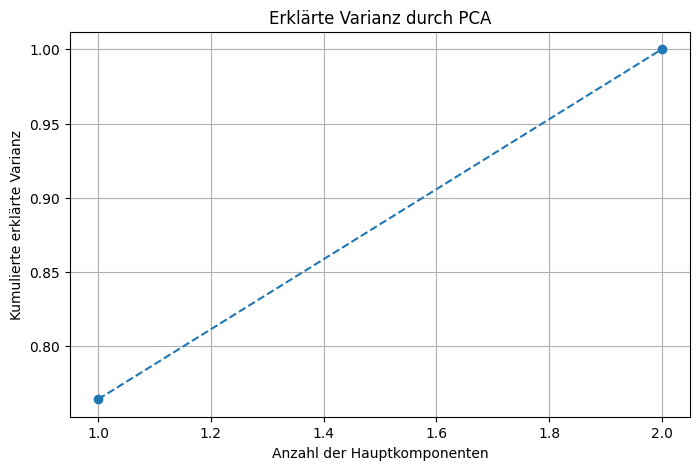

Anzahl der benötigten Hauptkomponenten für ~95% der Varianz: 2


In [17]:
#Prüfen ob PCA relevant ist

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Relevante numerische Features für PCA auswählen
numeric_features = ["playtime_forever", "playtime_2weeks"]

# Daten filtern: Nur numerische Spalten behalten und fehlende Werte entfernen
df_pca = df[numeric_features].dropna()

# Log-Transformation zur Normalisierung extremer Werte (optional)
df_pca = df_pca.replace(0, np.nan).dropna()  # Entferne Einträge mit 0 Spielzeit
df_pca = np.log1p(df_pca)  # log(1 + x), um extreme Werte zu reduzieren

# Standardisierung der Daten (wichtig für PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pca)

# PCA durchführen
pca = PCA()
pca.fit(df_scaled)

# Kumulierte erklärte Varianz berechnen
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot der erklärten Varianz
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Anzahl der Hauptkomponenten")
plt.ylabel("Kumulierte erklärte Varianz")
plt.title("Erklärte Varianz durch PCA")
plt.grid()
plt.show()

# Prüfen, wie viele Hauptkomponenten mindestens 95 % der Varianz erklären
num_components = np.argmax(explained_variance >= 0.95) + 1

print(f"Anzahl der benötigten Hauptkomponenten für ~95% der Varianz: {num_components}")


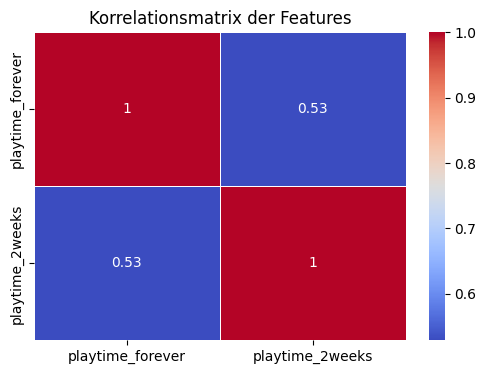

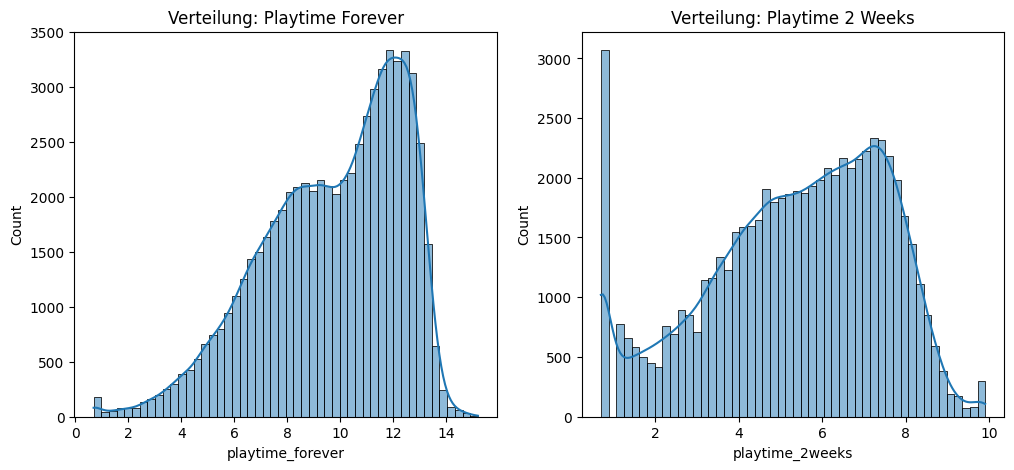

Silhouette-Score ohne PCA: 0.3609
Silhouette-Score mit PCA: 0.3609


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1️⃣ Korrelation zwischen den Features prüfen
plt.figure(figsize=(6, 4))
sns.heatmap(df_pca.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Korrelationsmatrix der Features")
plt.show()

# 2️⃣ Verteilung der Features prüfen
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_pca["playtime_forever"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Verteilung: Playtime Forever")
sns.histplot(df_pca["playtime_2weeks"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Verteilung: Playtime 2 Weeks")
plt.show()

# 3️⃣ Clustering testen mit und ohne PCA
# Ohne PCA
kmeans_original = KMeans(n_clusters=3, random_state=42)
clusters_original = kmeans_original.fit_predict(df_scaled)
silhouette_original = silhouette_score(df_scaled, clusters_original)

# Mit PCA
df_pca_transformed = pca.transform(df_scaled)[:, :2]  # Nur die ersten 2 Komponenten
kmeans_pca = KMeans(n_clusters=3, random_state=42)
clusters_pca = kmeans_pca.fit_predict(df_pca_transformed)
silhouette_pca = silhouette_score(df_pca_transformed, clusters_pca)

print(f"Silhouette-Score ohne PCA: {silhouette_original:.4f}")
print(f"Silhouette-Score mit PCA: {silhouette_pca:.4f}")


Fazit: PCA verbessert Clusterqualität nicht. Originaldaten verwenden

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Cluster-Anzahl von 2 bis 50 testen
wcss = []  # Summe der quadratischen Abstände (Elbow-Methode)
silhouette_scores = []

for k in range(2, 51):  # Testen bis zu 50 Cluster
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(df_scaled)
    
    wcss.append(kmeans.inertia_)  # Elbow-Kriterium
    silhouette_scores.append(silhouette_score(df_scaled, clusters))  # Silhouette-Score

# Elbow-Plot
plt.figure(figsize=(8, 4))
plt.plot(range(2, 51), wcss, marker='o', linestyle='--')
plt.xlabel("Anzahl der Cluster")
plt.ylabel("WCSS (Summe der quadratischen Abstände)")
plt.title("Elbow-Methode zur Bestimmung der Cluster-Anzahl")
plt.grid()
plt.show()

# Silhouette-Score-Plot
plt.figure(figsize=(8, 4))
plt.plot(range(2, 51), silhouette_scores, marker='o', linestyle='--', color='red')
plt.xlabel("Anzahl der Cluster")
plt.ylabel("Silhouette-Score")
plt.title("Silhouette-Score für verschiedene Cluster-Anzahlen")
plt.grid()
plt.show()

# Optimale Cluster-Anzahl ausgeben
optimal_k = np.argmax(silhouette_scores) + 2
print(f"Optimale Cluster-Anzahl: {optimal_k}")


KeyboardInterrupt: 